In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
pp = dict(surface='white', hemi='both', verbose=0)

In [2]:
info = get_info(kind='biosemi128')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s finished


# Simulate

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 1002.82it/s]


source data shape:  (1284, 20) (1284, 20)


100%|██████████| 2/2 [00:00<00:00, 200.52it/s]


Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


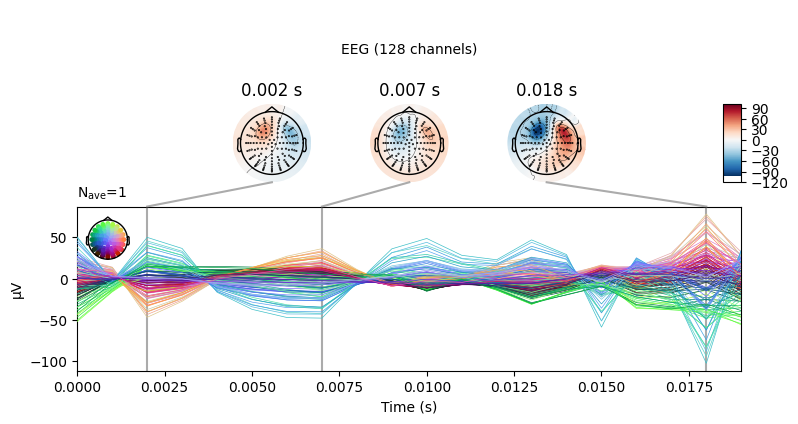

In [10]:
settings = dict(
    number_of_sources=4,
    extents=(24, 25),
    duration_of_trial=0.02,
    amplitudes=100,
    target_snr=1e99)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# Solve

c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))
c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


No projector specified for this dataset. Please consider the method self.add_proj.


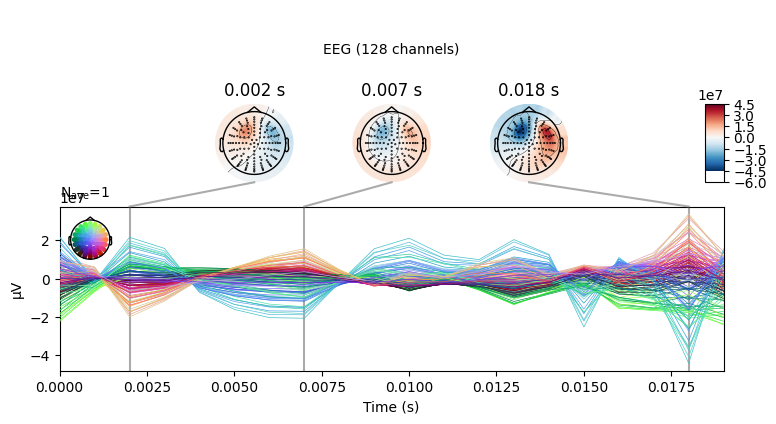

In [11]:
from invert import Solver
solver = Solver("gamma-map")
solver.make_inverse_operator(fwd, evoked, alpha=1e-6)
stc_ = solver.apply_inverse_operator(evoked,)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info)
evoked_.plot_joint()

No projector specified for this dataset. Please consider the method self.add_proj.


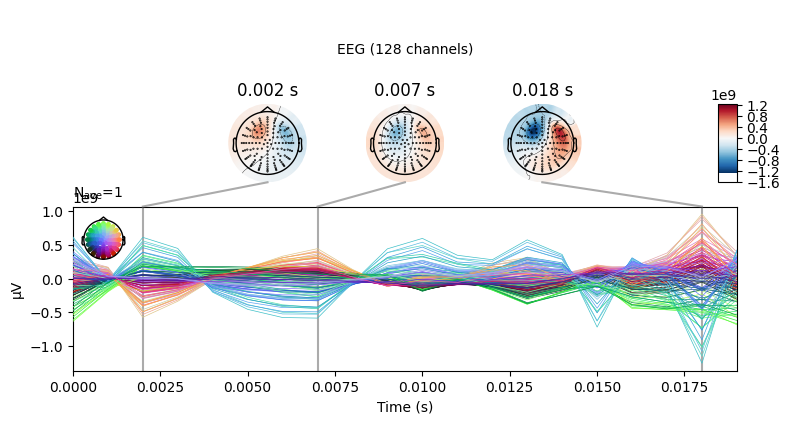

Using control points [0.08866764 0.1157931  0.77761647]
Using control points [0.04403689 0.06095037 0.18490478]
Using control points [0.03598064 0.06455453 0.80505275]
Using control points [0.04403689 0.06095037 0.18490478]


In [16]:
from invert import Solver
solver = Solver("source-map")
solver.make_inverse_operator(fwd, evoked, alpha=1e-6, p=1.9)
stc_ = solver.apply_inverse_operator(evoked,)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info)
evoked_.plot_joint()

No projector specified for this dataset. Please consider the method self.add_proj.


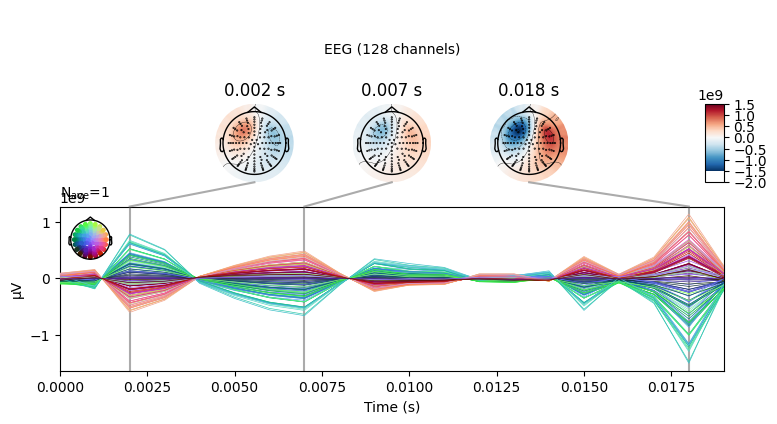

Using control points [9.92437368e-06 1.33105786e-03 5.21453910e-01]
Using control points [0.00666288 0.01010122 0.21943114]


In [13]:
from invert import Solver
solver = Solver("bcs")
solver.make_inverse_operator(fwd, evoked, alpha=1e-6)
stc_ = solver.apply_inverse_operator(evoked,)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info)
evoked_.plot_joint()

0  Res var:  12.17
1  Res var:  7.15
2  Res var:  4.64
3  Res var:  4.24
4  Res var:  4.07
5  Res var:  3.77
6  Res var:  3.41
7  Res var:  3.2
8  Res var:  3.14
9  Res var:  3.1
10  Res var:  2.98
11  Res var:  2.65
12  Res var:  2.47
13  Res var:  2.15
14  Res var:  1.71
15  Res var:  1.1
16  Res var:  0.6
17  Res var:  0.46
18  Res var:  0.46
19  Res var:  0.46
20  Res var:  0.46
21  Res var:  0.46
22  Res var:  0.46
23  Res var:  0.46
24  Res var:  0.46
No projector specified for this dataset. Please consider the method self.add_proj.


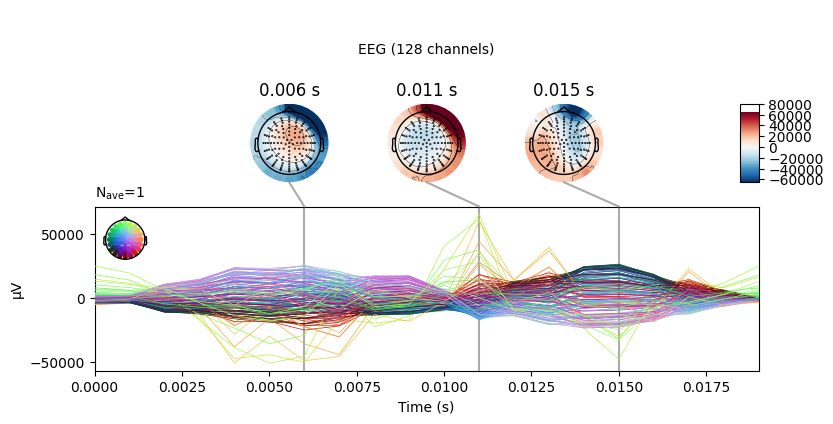

Using control points [0.         0.00303523 0.15466273]
Using control points [0.         0.0004533  0.09292869]
Using control points [5.10024856e-04 1.04997855e-02 5.39998335e-01]
Using control points [5.10024856e-04 1.04997855e-02 5.39998335e-01]
Using control points [0.00135027 0.00776377 0.88289822]
Using control points [0.         0.0011     0.25311585]
Using control points [0.         0.00801282 0.40999902]
Using control points [0.0020053  0.04128265 0.51221925]
Using control points [0.         0.00146539 0.41066754]
Using control points [0.         0.01176815 0.61055804]
Using control points [3.19367834e-04 1.83629465e-03 5.62576047e-01]
Using control points [1.08477224e-04 2.23320015e-03 1.00000000e+00]
Using control points [0.         0.00056689 0.1144505 ]
Using control points [0.         0.00070941 0.03129889]
Using control points [0.00134938 0.01652813 0.77051429]
Using control points [0.0002096  0.00147125 0.06354297]


In [9]:
from invert.adapters import stampc
stc_stamp = stampc(stc_, evoked, fwd, n_orders=2, rv_thresh=0.1)
stc_stamp.data /= abs(stc_stamp.data).max()
brain = stc_stamp.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_stamp.data, info)
evoked_.plot_joint()

In [ ]:
from invert import Solver
solver = Solver("Champagne")
solver.make_inverse_operator(fwd, evoked, alpha="auto")
stc_ = solver.apply_inverse_operator(evoked)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info)
evoked_.plot_joint()

# Big Loop

In [ ]:
from invert import Solver
# from invert.config import all_solvers
from invert.evaluate import nmse, corr, eval_mean_localization_error, eval_auc
from invert.adapters import contextualize_bd
import pickle as pkl


# all_solvers = [ "SOMP", "SSMP", "SubSMP", "MNE", "dSPM", "LORETA", "eLORETA", "Bayesian Beamformer LORETA"]
settings = dict(number_of_sources=(1, 4), extents=(1, 25), duration_of_trial=0.1, target_snr=1e99)



solvers = dict(FC=solver)
errors_corr = {sname: [] for sname in solvers.keys()}
errors_mle = {sname: [] for sname in solvers.keys()}
errors_auc = {sname: [] for sname in solvers.keys()}

errors_corr["FC_camp"] = []
errors_mle["FC_camp"] = []
errors_auc["FC_camp"] = []

for i in range(200):
    print(i)
    sim = Simulation(fwd, info, settings).simulate(2)
    stc = sim.source_data[0]
    evoked = sim.eeg_data[0].average()

    for solver_name in solvers.keys():
        solver = solvers[solver_name]
        stc_hat = solvers[solver_name].apply_inverse_operator(evoked)
        
        error_corr = np.mean(corr(stc.data, stc_hat.data))
        error_mle = eval_mean_localization_error(stc.data[:, 0], stc_hat.data[:, 0], pos)
        error_auc = eval_auc(stc.data[:, 0], stc_hat.data[:, 0], pos)

        errors_corr[solver_name].append( error_corr )
        errors_mle[solver_name].append( error_mle )
        errors_auc[solver_name].append( error_auc )

        stc_hat = stampc(stc_hat, evoked, fwd, n_orders=1, rv_thresh=0.1)

        error_corr = np.mean(corr(stc.data, stc_hat.data))
        error_mle = eval_mean_localization_error(stc.data[:, 0], stc_hat.data[:, 0], pos)
        error_auc = eval_auc(stc.data[:, 0], stc_hat.data[:, 0], pos)

        errors_corr[solver_name + "_camp"].append( error_corr )
        errors_mle[solver_name + "_camp"].append( error_mle )
        errors_auc[solver_name + "_camp"].append( error_auc )
        
        # print(error_corr, error_mle, error_auc)
    
    # print("Saving errors")
    # fn = "errors.pkl"
    # with open(fn, 'wb') as f:
    #     pkl.dump(errors, f)

In [ ]:
from invert import Solver
# from invert.config import all_solvers
from invert.evaluate import nmse, corr, eval_mean_localization_error, eval_auc
from invert.adapters import contextualize_bd
import pickle as pkl


all_solvers = [ "SOMP", "SSMP", "SubSMP", "MNE", "dSPM", "LORETA", "eLORETA", "Bayesian Beamformer LORETA"]
settings = dict(number_of_sources=(1, 4), extents=(1, 25), duration_of_trial=0.1, target_snr=1e99)

# errors_corr = {sname: [] for sname in all_solvers}
# errors_mle = {sname: [] for sname in all_solvers}
# errors_auc = {sname: [] for sname in all_solvers}

# solvers = dict()

for i in range(20):
    print(i)
    sim = Simulation(fwd, info, settings).simulate(2)
    stc = sim.source_data[0]
    evoked = sim.eeg_data[0].average()

    for solver_name in all_solvers:
        print(solver_name)
        solver = Solver(solver=solver_name)
        if (not solver_name in solvers):
            solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha="auto")
        stc_hat = solvers[solver_name].apply_inverse_operator(evoked)
        # stc_hat.plot(**pp, brain_kwargs=dict(title=solver.name))
        # error = np.mean(corr(stc.data, stc_hat.data))
        
        error_corr = np.mean(corr(stc.data, stc_hat.data))
        try:
            error_mle = eval_mean_localization_error(stc.data[:, 0], stc_hat.data[:, 0], pos)
        except:
            error_mle = np.nan
        error_auc = eval_auc(stc.data[:, 0], stc_hat.data[:, 0], pos)

        errors_corr[solver_name].append( error_corr )
        errors_mle[solver_name].append( error_mle )
        errors_auc[solver_name].append( error_auc )
        # print(error_corr, error_mle, error_auc)
    
    # print("Saving errors")
    # fn = "errors.pkl"
    # with open(fn, 'wb') as f:
    #     pkl.dump(errors, f)

In [ ]:
# import pickle as pkl
# fn = "errors.pkl"
# with open(fn, 'rb') as f:
#     errors = pkl.load(f)

# Plot

In [ ]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=0.8)

df = pd.DataFrame(errors_corr)
# df = pd.DataFrame(errors_mle)
# df = pd.DataFrame(errors_auc)

sorted_index = df.median().sort_values().index
df = df[sorted_index]

plt.figure()
sns.boxplot(data=df)
plt.title("Correlation with ground truth")


df_mean_var = pd.concat([df.mean(), df.std()], axis=1)
df_mean_var = df_mean_var.rename(columns={0: "Median", 1: "Variance"})
df_mean_var["MedVar"] = df_mean_var["Median"] / df_mean_var["Variance"]
df_mean_var["Method"] = df_mean_var.index
display(df_mean_var)

plt.figure()
sns.scatterplot(x="Median", y="Variance", hue="Method", size="MedVar", data=df_mean_var)
plt.xlabel("Median")
plt.ylabel("Variance")


In [ ]:
settings = dict(number_of_sources=3, extents=(25, 35), duration_of_trial=0.025, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

In [ ]:
# from invert.solvers.empirical_bayes import SolverChampagne
# from invert.solvers.esinet import SolverFullyConnected
# solver_fc = SolverFullyConnected().make_inverse_operator(fwd, evoked)
# solver_ch = SolverChampagne().make_inverse_operator(fwd, evoked)
from invert.evaluate import nmse, corr

stc_hat = solver_ch.apply_inverse_operator(evoked)
stc_hat.plot(**pp)
# brain.add_text(0.1, 0.9, "Champagne", 'title',
#                font_size=14)
error_ch = np.mean(corr(abs(stc.data), abs(stc_hat.data)))

stc_hat = solver_fc.apply_inverse_operator(evoked)
stc_hat.plot(**pp)
# brain.add_text(0.1, 0.9, "Fully-Connected", 'title',
#                font_size=14)
error_fc = np.mean(corr(abs(stc.data), abs(stc_hat.data)))

print(f"Champ: {error_ch}\nFC: {error_fc}")